# MCBDD 2024 Module II Offline Activity


Benjamin Duvor, April 2024

### Task 1

Retrieving all approved drugs from the ChEMBL database, sorting them by approval year and name

In [1]:
from chembl_webresource_client.new_client import new_client
import requests
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

In [2]:
# Getting all drugs

drugs = new_client.drug
len(drugs)


15502

In [3]:
drugs[0]

{'applicants': ['Pfizer Inc',
  'Mylan Pharmaceuticals Inc',
  'Mankind Pharma Ltd',
  'Alembic Pharmaceuticals Ltd',
  'Granules Pharmaceuticals Inc',
  'Pfizer Laboratories Div Pfizer Inc',
  'Appco Pharma Llc',
  'Ivax Pharmaceuticals Inc Sub Teva Pharmaceuticals Usa',
  'Dava Pharmaceuticals Inc',
  'Aurobindo Pharma Ltd'],
 'atc_classification': [{'code': 'C02CA01',
   'description': 'CARDIOVASCULAR SYSTEM: ANTIHYPERTENSIVES: ANTIADRENERGIC AGENTS, PERIPHERALLY ACTING: Alpha-adrenoreceptor antagonists'}],
 'availability_type': 1,
 'biotherapeutic': None,
 'black_box': 0,
 'black_box_warning': '0',
 'chirality': 2,
 'drug_type': 1,
 'first_approval': 1976,
 'first_in_class': 0,
 'helm_notation': None,
 'indication_class': 'Antihypertensive',
 'max_phase': '4.0',
 'molecule_chembl_id': 'CHEMBL2',
 'molecule_properties': {'alogp': '1.78',
  'aromatic_rings': 3,
  'cx_logd': '1.43',
  'cx_logp': '1.65',
  'cx_most_apka': None,
  'cx_most_bpka': '7.24',
  'full_molformula': 'C19H21N5O4

In [4]:
def get_chembl(drug: list):
    """ return ChEMBL ID"""
    return drug['molecule_chembl_id']

get_chembl(drugs[0])


'CHEMBL2'

In [5]:
def get_FirstApproval(drug: list):
    """ returns the year of first approval"""
    return drug['first_approval']


get_FirstApproval(drugs[0])


1976

In [6]:
drugs[0]['molecule_synonyms']

[{'molecule_synonym': 'CP-12299',
  'syn_type': 'RESEARCH_CODE',
  'synonyms': 'CP-12299'},
 {'molecule_synonym': 'CP-122991',
  'syn_type': 'RESEARCH_CODE',
  'synonyms': 'CP-122991'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'FDA', 'synonyms': 'Prazosin'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'ATC', 'synonyms': 'PRAZOSIN'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'BAN', 'synonyms': 'PRAZOSIN'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'INN', 'synonyms': 'PRAZOSIN'},
 {'molecule_synonym': 'Prazosin',
  'syn_type': 'MERCK_INDEX',
  'synonyms': 'PRAZOSIN'},
 {'molecule_synonym': 'Prazosin', 'syn_type': 'OTHER', 'synonyms': 'PRAZOSIN'}]

In [7]:
def get_INN(drug: list):
    """returns INN name, use ; as concatenator if more than one value is available"""
    inn = [x['molecule_synonym'] for x in drug['molecule_synonyms'] if x['syn_type'] == 'INN']
    res = ';'.join(inn)
    return(res)


get_INN(drugs[0])



'Prazosin'

In [8]:
ids = [get_chembl(x) for x in drugs]
years = [get_FirstApproval(x) for x in drugs]
names = [get_INN(x) for x in drugs]


In [9]:
task1 = pd.DataFrame({'ID':ids, 'Name':names, 'FirstApproval':years})
task1.sort_values(by=['Name', 'FirstApproval'], axis=0, inplace=True)
print(task1)


                  ID               Name  FirstApproval
272         CHEMBL90                            1939.0
1079       CHEMBL821                            1939.0
2935       CHEMBL190                            1940.0
4656   CHEMBL1201649                            1942.0
4363   CHEMBL1201235                            1943.0
...              ...                ...            ...
1328     CHEMBL53904     Zuclopenthixol            NaN
12451  CHEMBL4105630         Zuranolone         2023.0
12919  CHEMBL4297637  Zuretinol acetate            NaN
14715  CHEMBL5095426     Zurletrectinib            NaN
12214  CHEMBL3989838       Zylofuramine            NaN

[15502 rows x 3 columns]


In [10]:
task1.to_csv('20230507-ChEMBL-drugs-sorted-by-name-and-approval.tsv.gz', sep='\t')

### Task 2

Retrieve a list of UniProt accession numbers, namely protein targets associated with drugs approved since 2014

In [10]:
# Getting all approved drugs since the year 2014

approved_s2014_df = task1.query('FirstApproval >= 2014')\
                         .sort_values(by='FirstApproval', axis = 0)
print(approved_s2014_df)

                  ID           Name  FirstApproval
2251    CHEMBL139367                        2014.0
8609   CHEMBL2107841    Albiglutide         2014.0
1060    CHEMBL441738  Afamelanotide         2014.0
6205   CHEMBL2103822    Tasimelteon         2014.0
10801  CHEMBL2216870     Idelalisib         2014.0
...              ...            ...            ...
11663  CHEMBL3643413     Leniolisib         2023.0
11914  CHEMBL3833321      Lecanemab         2023.0
10994  CHEMBL2397415     Zavegepant         2023.0
11927  CHEMBL3833346       Tofersen         2023.0
12451  CHEMBL4105630     Zuranolone         2023.0

[569 rows x 3 columns]




Next we query UniProts of targets associated with each drug molecule. The query is done in two steps: first we find ChEMBL identifiers of targets, and then we translate these ChEMBL identifiers to UniProt identifiers.



In [11]:
drugs_approved_s2024 = approved_s2014_df.ID[0:50]

comp2target = dict()
for d in drugs_approved_s2024:
    comp2target[d] = set()

# Process compounds in chunks so that we prevent huge queries:
chunk_size = 25
keys = list(comp2target.keys())

for i in range(0, len(keys), chunk_size):
    # we jump from compounds to targets through activities:
    activities = new_client.activity.filter(molecule_chembl_id__in=keys[i:i + chunk_size]).only(
        ['molecule_chembl_id', 'target_chembl_id'])
    # extracting target ChEMBL IDs from activities:
    for act in activities:
        comp2target[act['molecule_chembl_id']].add(act['target_chembl_id'])

# Now our dictionary maps from compound ChEMBL IDs into target ChEMBL IDs
# We next translate the identifier of targets from ChEMBL IDs to UniProt IDs
for key, val in comp2target.items():
    # We don't know how many targets are associated with any compound. Therefore it is
    # better to process targets in chunks, as suggested by the ChEMBL webclient.
    lval = list(val)
    uniprots = set()
    for i in range(0, len(val), chunk_size):
        targets = new_client.target.filter(target_chembl_id__in=lval[i:i + chunk_size]).only(
            ['target_components'])
        uniprots |= {comp['accession'] for t in targets for comp in t['target_components']}

    comp2target[key] = uniprots

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [ ]:
comp2target_df = pd.DataFrame([(i, uniprot) for i, j in comp2target.items() for uniprot in j], 
                  columns=['ID','UniProt'])
print(comp2target_df)

In [14]:
# Exporting results into a tab-delimited file

comp2target_df.to_csv('20230507-ChEMBL-drugs-since-2014-UniProt.tsv.gz', sep='\t')

Finding on average the protein targets associated with each compound

In [16]:
df_averages = pd.read_csv('20230507-ChEMBL-drugs-since-2014-UniProt.tsv.gz', sep='\t', index_col=0)

# Group the data by UniProt IDs and count the number of unique IDs for each uniprot
uniprot_counts = df_averages.groupby('UniProt')['ID'].nunique()

# Calculate the average count
average_count = uniprot_counts.mean()

print('Average count of Chems associated with each unique Uniprot:', average_count)

Average count of Chems associated with each unique Uniprot: 3.115032679738562


### Task 3

For each protein with a UniProt accession number that you identified in step (2),retrieve UniProt keywords associated with it.

The REST API of UniProt accepts maximum 100 proteins in one go, that's why I retrieved the keywords of 100 proteins.


In [17]:
## read in results of task 2

task2_res = pd.read_csv('20230507-ChEMBL-drugs-since-2014-UniProt.tsv.gz', sep='\t', index_col=0)

In [18]:
uniq_uniprot = set(task2_res.UniProt)
sel_uniprot = list(uniq_uniprot)[:100]
sel_uniprot_queryid = ','.join(sel_uniprot)

In [19]:
url = 'https://www.ebi.ac.uk/proteins/api/proteins?offset=0&size=100&accession='+sel_uniprot_queryid
r = requests.get(url, headers={'Accept': 'application/json'})

In [20]:
# The keywords of the first protein can be found here
keywords = [list(k.values())[0] for k in r.json()[0]['keywords']]
print(keywords)

['Calcium', 'Disulfide bond', 'Glycoprotein', 'Glycosidase', 'Host cell membrane', 'Host membrane', 'Hydrolase', 'Membrane', 'Metal-binding', 'Signal-anchor', 'Transmembrane', 'Transmembrane helix', 'Virion']


In [21]:
len(r.json())

100

In [22]:
# Fetch all keywords
def get_keywords(protein: list):
    res = [list(k.values())[0] for k in protein['keywords']]
    if res == None:
        res = []
    return(res)

all_keywords=[]
for jlist in r.json():
    all_keywords.extend(get_keywords(jlist))
    
keyword_counter = Counter(all_keywords)
print(keyword_counter)


Counter({'Reference proteome': 95, '3D-structure': 82, 'Phosphoprotein': 74, 'Alternative splicing': 67, 'Membrane': 56, 'Nucleotide-binding': 56, 'ATP-binding': 54, 'Transferase': 48, 'Kinase': 43, 'Cytoplasm': 40, 'Nucleus': 40, 'Cell membrane': 38, 'Transmembrane': 37, 'Transmembrane helix': 37, 'Glycoprotein': 36, 'Metal-binding': 35, 'Disulfide bond': 33, 'Receptor': 32, 'Serine/threonine-protein kinase': 30, 'Ubl conjugation': 24, 'Acetylation': 20, 'Disease variant': 19, 'G-protein coupled receptor': 19, 'Transducer': 19, 'Magnesium': 18, 'Repeat': 17, 'Tyrosine-protein kinase': 15, 'Lipoprotein': 15, 'Transcription': 15, 'Transcription regulation': 15, 'Direct protein sequencing': 14, 'Cell cycle': 13, 'Cell projection': 13, 'Signal': 12, 'Cytoskeleton': 12, 'Isopeptide bond': 11, 'Palmitate': 11, 'Hydrolase': 10, 'Zinc': 10, 'Cell division': 10, 'Apoptosis': 10, 'DNA-binding': 9, 'Endoplasmic reticulum': 9, 'Synapse': 8, 'Lipid metabolism': 8, 'Host-virus interaction': 8, 'Zin

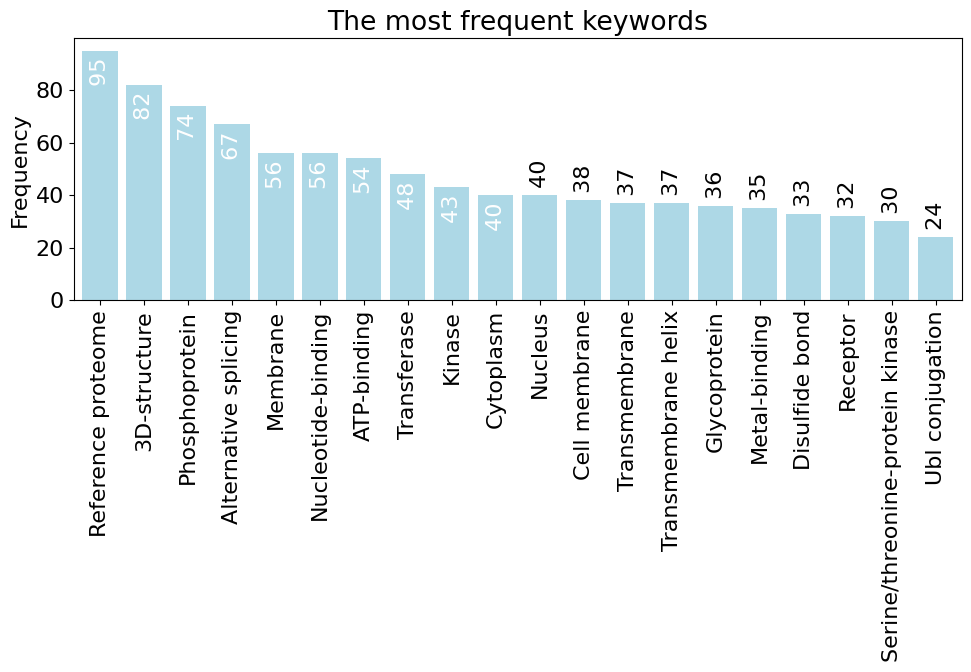

In [23]:
most_common_keywords = keyword_counter.most_common(20)
y = [count for keyword, count in most_common_keywords]
x = [keyword for keyword, count in most_common_keywords]

plt.rcParams["figure.figsize"] = (10,7)
plt.rcParams.update({'font.size': 16})

plt.bar(x, y, color='lightblue')
plt.title("The most frequent keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
for i, (tag, count) in enumerate(most_common_keywords):
    plt.text(i, count, f' {count} ', rotation=90, size=16,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()